In [21]:
# # https://pypi.org/project/quickdraw
# from quickdraw import QuickDrawData
import numpy as np
import urllib.request
import os
import glob as gb
import pathlib
import random
import torch
import matplotlib
import matplotlib.pyplot as plt
from torch.utils.data import random_split, TensorDataset, DataLoader

In [19]:
# 난수 고정
def set_seed(seed):
    # os.environ['PYTHONASHSEED'] = 0 무작위화 비활성화
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)

# 이미지 저장
def save_figure(figure_name, figure_base_path = './figure/', figure_extension='.png', resolution=300):
    # make directory
    try:
        if not os.path.exists(figure_base_path):
            os.makedirs(figure_base_path)
    except:
      print('already exists')
    
    figure_path = figure_base_path + figure_name + figure_extension
    print('save figure: ', figure_name)
    
    plt.savefig(figure_path, bbox_inches='tight', format=figure_extension[1:], dpi=resolution)
    
    
set_seed(1)

## Prepare Dataset

In [25]:
# Get image labels
def get_labels():
  f = open('./30_labels.txt', 'r')
  labels = f.readlines()
  f.close()
  
  labels = [l.replace('\n', '') for l in labels]
  return labels

In [26]:
def load_dataset():
  # make directory
  dataset_path = './dataset/'
  try:
    if not os.path.exists(dataset_path):
      os.makedirs(dataset_path)
  except:
      None
      
  # get data from web
  labels = get_labels()
  base_url = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/'
  for label in labels:
    label_url = label.replace('_', '%20')
    npy_url = base_url + label_url + '.npy'
    print(npy_url)
    urllib.request.urlretrieve(npy_url, dataset_path + label + '.npy')

  print('Done!')
  
load_dataset()

https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/airplane.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/apple.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/banana.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/baseball.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/bear.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/bicycle.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/bird.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/bus.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/cat.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/cup.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/dog.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/duck.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/fish.npy
ht

In [110]:
import torchvision.transforms as transforms

In [114]:
# https://stackoverflow.com/questions/44429199/how-to-load-a-list-of-numpy-arrays-to-pytorch-dataset-loader
# https://velog.io/@dust_potato/Data-Augmentation-%EC%96%B4%EB%96%A4-transform%EC%9D%84-%EC%A4%98%EC%95%BC-%EC%9E%98%ED%96%88%EB%8B%A4%EA%B3%A0-%EC%86%8C%EB%AC%B8%EC%9D%B4-%EB%82%A0%EA%B9%8C

def prepare_dataset(test_ratio=0.2, max_items_per_class=10000):
    npy_files = gb.glob('./dataset/*.npy')

    #initialize variables 
    x = np.empty([0, 784]) # 28*28 =784
    y = np.empty([0])
    classes = []

    #load a subset of the data to memory 
    for idx, npy_file in enumerate(npy_files):
        data = np.load(npy_file)
        data = data[0: max_items_per_class, :]
        labels = np.full(data.shape[0], idx)

        x = np.concatenate((x, data), axis=0)
        y = np.append(y, labels)
    
        label, extension = os.path.splitext(os.path.basename(npy_file))
        classes.append(label)

    data = None
    labels = None
    
    # transform to torch tensor
    tensor_x = torch.Tensor(x)
    tensor_x = tensor_x.reshape(tensor_x.shape[0], 1, 28, 28)
    # normalizatoin
    tensor_x /= 255.0
    tensor_y = torch.Tensor(y)
    
    # create dataset
    dataset = TensorDataset(tensor_x, tensor_y)

    #separate into train data and test data
    lengths = [int(len(dataset)*(1-test_ratio)), int(len(dataset)*test_ratio)]
    
    train_dataset, test_dataset = random_split(dataset=dataset, lengths=lengths)
    
    return train_dataset, test_dataset, classes

## Check Device

In [115]:
# Get cpu or gpu device for training.
if torch.cuda.is_available():
  DEVICE = torch.device('cuda:0')
else:
  DEVICE = torch.deivce('cpu')

print('Using Pytorch version : ',  torch.__version__, 'DEVICE : ', DEVICE)

Using Pytorch version :  1.12.1 DEVICE :  cuda:0


## Data Loader

In [116]:
train_dataset, test_dataset, classes = prepare_dataset()

In [117]:
# hyperparameter
BATCH_SIZE = 128
EPOCHS = 30

In [118]:
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [119]:
for (X_train, y_train) in train_loader:
  print(f'Shape of X_train [N, C, H, W] : {X_train.shape}', f'\nType of X_train : {X_train.dtype}\n')  # X_train.type() : torch.FloatTensor
  print(f'Shape of y_train [N, C, H, W] : {y_train.shape}', f'\nType of y_train : {y_train.dtype}\n')  # y_traon.type() : torch.LongTensor
  break

Shape of X_train [N, C, H, W] : torch.Size([128, 1, 28, 28]) 
Type of X_train : torch.float32

Shape of y_train [N, C, H, W] : torch.Size([128]) 
Type of y_train : torch.float32



## Data Visualization

In [120]:
def imshow(img, label):
  img = img / 2 + 0.5  # unnormalize
  npimg = img.numpy()
  plt.figure(figsize=(5, 5))
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.axis('off')
  save_figure(label)
  plt.show()

def idx_to_class(y_idx):
  return classes[int(y_idx.item())]

save figure:  house


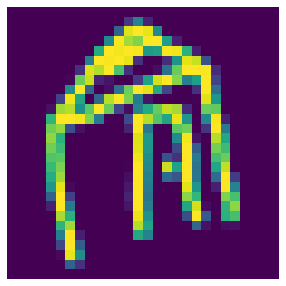

In [121]:
data_iter = iter(train_loader)
images, labels = next(data_iter)

imshow(images[0], idx_to_class(labels[0]))

save figure:  quickdraw_visualization


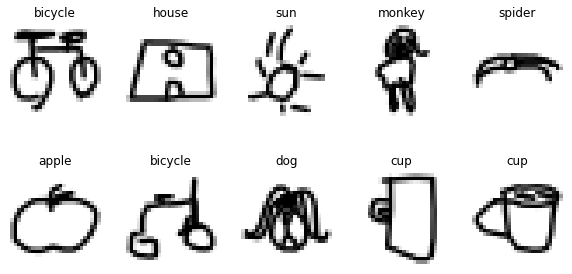

In [122]:
plt.figure(figsize=(10, 5))

for i in range(10):
  plt.subplot(2, 5, i+1)
  plt.axis('off')
  plt.imshow(X_train[i, :, :, :].squeeze(), cmap='binary')  # X_train [32, 1, 28, 28] -> [i, :, :, :] -> squeeze() -> [28, 28]
  plt.title(idx_to_class(y_train[i]))
  
save_figure('quickdraw_visualization')

## Model

In [145]:
#Importing PyTorch module

import time
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torchvision import models
from torchvision import transforms
from torchsummary import summary

In [166]:
resnet50 = models.resnet50(pretrained=True)

num_classes = len(classes)
resnet50.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3)
resnet50.fc = nn.Linear(resnet50.fc.in_features, num_classes)

resnet50.to(DEVICE)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=Fal

In [181]:
optimizer = optim.Adam(resnet50.parameters(), lr=1e-4)
sheduler = optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=10, gamma=0.5)
criterion = nn.CrossEntropyLoss()

resnet50

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=Fal

In [169]:
summary(resnet50, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           3,200
       BatchNorm2d-2           [-1, 64, 14, 14]             128
              ReLU-3           [-1, 64, 14, 14]               0
         MaxPool2d-4             [-1, 64, 7, 7]               0
            Conv2d-5             [-1, 64, 7, 7]           4,096
       BatchNorm2d-6             [-1, 64, 7, 7]             128
              ReLU-7             [-1, 64, 7, 7]               0
            Conv2d-8             [-1, 64, 7, 7]          36,864
       BatchNorm2d-9             [-1, 64, 7, 7]             128
             ReLU-10             [-1, 64, 7, 7]               0
           Conv2d-11            [-1, 256, 7, 7]          16,384
      BatchNorm2d-12            [-1, 256, 7, 7]             512
           Conv2d-13            [-1, 256, 7, 7]          16,384
      BatchNorm2d-14            [-1, 25

## Train

In [195]:
def train(model, train_loader, criterion, optimizer, DEVICE):  
    """
    Training function 
    Input : Model, Iterator = train data loader, Optimizer function,
            Criterian, device = cuda or cpu 
    Output: Training Loss and Training Accuracy
    """
    epoch_loss = 0
    epoch_acc = 0
    model.train()

    for (X, y) in train_loader:
        X = X.float().to(DEVICE)
        y = y.type(torch.LongTensor).to(DEVICE)
        
        # preciction error
        y_pred = model(X)
        loss = criterion(y_pred, y)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        acc = calculate_accuracy(y_pred, y)
        epoch_loss += loss.item()
        epoch_acc += acc.item()

    train_acc_list.append(epoch_acc/len(train_loader)) 
    train_loss_list.append(epoch_loss/len(train_loader)) 
        
    return epoch_loss / len(train_loader), epoch_acc / len(train_loader) , train_loss_list, train_acc_list

def evaluate(model, test_loader, criterion, DEVICE):  
    """
    Evaluation Function
    Input : Model, iterator = test data loader, criterian of loss,
            device = cuda or cpu
    Output: Test loss, test accuracy
    """
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
        for (X, y) in test_loader:
            X = X.float().to(DEVICE)
            y = y.type(torch.LongTensor).to(DEVICE)

            y_pred = model(X)
            loss = criterion(y_pred, y)
            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
    
    test_acc_list.append(epoch_acc/len(test_loader)) 
    test_loss_list.append(epoch_loss/len(test_loader))

    return epoch_loss / len(test_loader), epoch_acc / len(test_loader) , test_loss_list, test_acc_list

def epoch_time(start_time, end_time):
    """
    Function to calculate total time taken in an epoch
    """
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


In [196]:
def count_parameters(model):
    """
    Counts the number of trainable parameters
    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def calculate_accuracy(y_pred, y):
    """
    Calculates the accuracy of training/evaluating
    """
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [ ]:
train_acc_list, train_loss_list = [], []
test_acc_list, test_loss_list = [], []

In [197]:
#collapse-hide
#Variable to monitor best validation loss
best_valid_loss = float('inf')

for epoch in range(EPOCHS):

    start_time = time.time()
    train_loss, train_acc, train_loss_list, train_acc_list = train(model, train_loader, criterion, optimizer, DEVICE)
    valid_loss, valid_acc, test_loss_list, test_acc_list = evaluate(model, test_loader, criterion, DEVICE)
    
    #Saving model whenver the best validation loss is obtained
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model.pt')
    end_time = time.time()
    epoch_mins, epoch_secs,  = epoch_time(start_time, end_time) #Monitoring Time
    print('-----------------------------------------------')
    print(f'Epoch: {epoch+1:02}    | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print('-----------------------------------------------')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\tVal. Loss: {valid_loss:.3f}  | Val. Acc: {valid_acc*100:.2f}%')
    

-----------------------------------------------
Epoch: 01    | Epoch Time: 0m 9s
-----------------------------------------------
	Train Loss: 1.417 | Train Acc: 66.29%
	Val. Loss: 1.455  | Val. Acc: 65.21%
-----------------------------------------------
Epoch: 02    | Epoch Time: 0m 9s
-----------------------------------------------
	Train Loss: 1.417 | Train Acc: 66.29%
	Val. Loss: 1.454  | Val. Acc: 65.22%
-----------------------------------------------
Epoch: 03    | Epoch Time: 0m 9s
-----------------------------------------------
	Train Loss: 1.417 | Train Acc: 66.29%
	Val. Loss: 1.454  | Val. Acc: 65.22%
-----------------------------------------------
Epoch: 04    | Epoch Time: 0m 10s
-----------------------------------------------
	Train Loss: 1.417 | Train Acc: 66.29%
	Val. Loss: 1.454  | Val. Acc: 65.22%
-----------------------------------------------
Epoch: 05    | Epoch Time: 0m 10s
-----------------------------------------------
	Train Loss: 1.417 | Train Acc: 66.29%
	Val. 

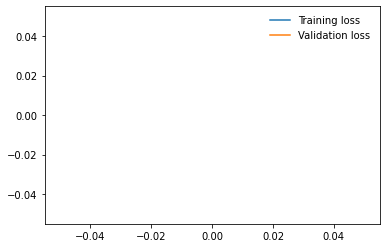

In [193]:
#collapse-hide
plt.plot(train_loss_list, label='Training loss')
plt.plot(test_loss_list, label='Validation loss')
plt.legend(frameon=False)

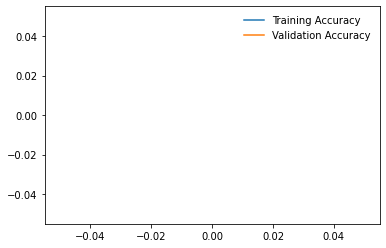

In [180]:
#collapse-hide
plt.plot(train_acc_list, label='Training Accuracy')
plt.plot(test_acc_list, label='Validation Accuracy')
plt.legend(frameon=False)